In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv("countries.csv")
test = pd.read_csv("test.csv")
train.countryname.fillna("None", inplace=True)

display(train.head())
display(train.describe())

display(test.head())
display(test.describe())

print("Number of Countries: ", train['countryname'].nunique())
print("Date Range:", min(train['day']), "to", max(train['day']), ", a total of", train['day'].nunique(), "days")
print("List of Countries: ", train.loc[train['countryname']!='None']['countryname'].unique())

,day,countryname,deaths,cumulativedeaths,confirmed,cumulativeconfirmed
0,2020-02-25,Afghanistan,0,0,1,1
1,2020-02-26,Afghanistan,0,0,0,1
2,2020-02-27,Afghanistan,0,0,0,1
3,2020-02-28,Afghanistan,0,0,0,1
4,2020-02-29,Afghanistan,0,0,0,1


,deaths,cumulativedeaths,confirmed,cumulativeconfirmed
count,6894.000000,6894.000000,6894.000000,6894.000000
mean,9.838555,113.079489,176.057296,2447.883667
std,72.718220,809.938307,1175.104687,13654.857008
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,4.000000
50%,0.000000,0.000000,2.000000,26.000000
75%,0.000000,3.000000,24.000000,239.000000
max,2003.000000,15889.000000,33510.000000,307318.000000


,forecastid,countryname,day
0,1,Afghanistan,4/8/20
1,2,Afghanistan,4/9/20
2,3,Afghanistan,4/10/20
3,4,Afghanistan,4/11/20
4,5,Afghanistan,4/12/20


,forecastid
count,11581.000000
mean,5791.000000
std,3343.291068
min,1.000000
25%,2896.000000
50%,5791.000000
75%,8686.000000
max,11581.000000


Number of Countries:  208
Date Range: 2020-01-09 to 2020-04-07 , a total of 90 days
List of Countries:  ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei Darussalam' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Congo' 'Costa Rica' 'Côte d’Ivoire' 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czechia' 'Democratic Republic of the Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Falkland Islands (Malvinas)' 'Faroe Islands' 'Fiji' 'Finland'
 'France' 'French Gui

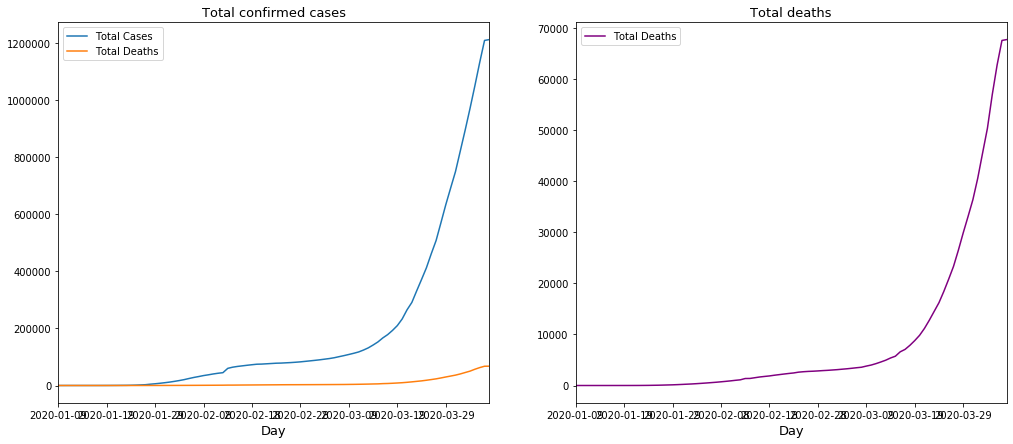

In [3]:
confirmed = train.groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths = train.groupby(['day']).agg({'cumulativedeaths':['sum']})
total = confirmed.join(deaths)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

total.plot(ax=ax1)
ax1.set_title("Total confirmed cases", size=13)
ax1.set_xlabel("Day", size=13)
ax1.legend(['Total Cases', 'Total Deaths'])

deaths.plot(ax=ax2, color='purple')
ax2.set_title("Total deaths", size=13)
ax2.set_xlabel("Day", size=13)
ax2.legend(['Total Deaths'])

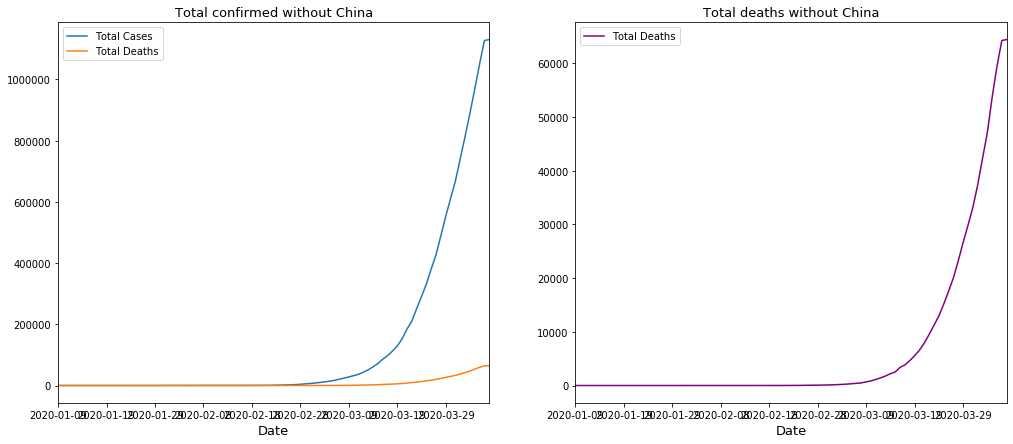

In [4]:
confirmed_withoutChina = train[train['countryname']!='China'].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_withoutChina = train[train['countryname']!='China'].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_withoutChina = confirmed_withoutChina.join(deaths_withoutChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_withoutChina.plot(ax=ax1)

ax1.set_title("Total confirmed without China", size=13)
ax1.set_xlabel("Date", size=13)
ax1.legend(['Total Cases', 'Total Deaths'])

deaths_withoutChina.plot(ax=ax2, color='purple')
ax2.set_title("Total deaths without China", size=13)
ax2.set_xlabel("Date", size=13)
ax2.legend(['Total Deaths'])

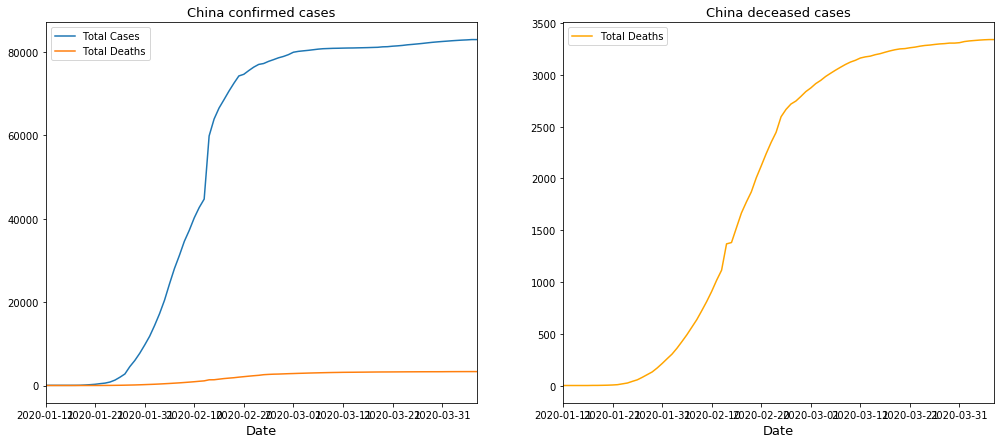

In [5]:
confirmed_justChina = train[train['countryname']=='China'].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_justChina = train[train['countryname']=='China'].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_justChina = confirmed_justChina.join(deaths_justChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_justChina.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_xlabel("Date", size=13)
ax1.legend(['Total Cases', 'Total Deaths'])

deaths_justChina.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_xlabel("Date", size=13)
ax2.legend(['Total Deaths'])

(0, 300000)

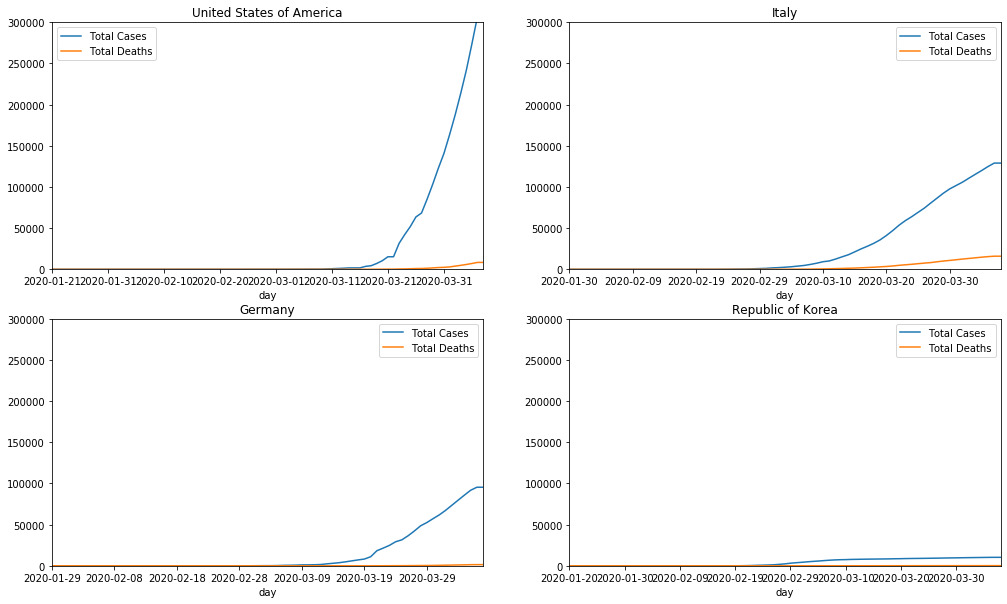

In [6]:
confirmed_USA = train[train['countryname']=='United States of America'].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_USA = train[train['countryname']=='United States of America'].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_USA = confirmed_USA.join(deaths_USA)

confirmed_Italy = train[train['countryname']=='Italy'].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_Italy = train[train['countryname']=='Italy'].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_Italy = confirmed_Italy.join(deaths_Italy)

confirmed_Germany = train[train['countryname']=='Germany'].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_Germany = train[train['countryname']=='Germany'].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_Germany = confirmed_Germany.join(deaths_Germany)

confirmed_SouthKorea = train[train['countryname']=='Republic of Korea'].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_SouthKorea = train[train['countryname']=='Republic of Korea'].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_SouthKorea = confirmed_SouthKorea.join(deaths_SouthKorea)

confirmed_Spain = train[train['countryname']=='Spain'].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_Spain = train[train['countryname']=='Spain'].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_Spain = confirmed_Spain.join(deaths_Spain)

plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
total_USA.plot(ax=plt.gca(), title='United States of America')
plt.legend(['Total Cases', 'Total Deaths'])
plt.ylim(0, 300000)

plt.subplot(2, 2, 2)
total_Italy.plot(ax=plt.gca(), title='Italy')
plt.legend(['Total Cases', 'Total Deaths'])
plt.ylim(0, 300000)

plt.subplot(2, 2, 3)
total_Germany.plot(ax=plt.gca(), title='Germany')
plt.legend(['Total Cases', 'Total Deaths'])
plt.ylim(0, 300000)

plt.subplot(2, 2, 4)
total_SouthKorea.plot(ax=plt.gca(), title='Republic of Korea')
plt.legend(['Total Cases', 'Total Deaths'])
plt.ylim(0, 300000)

(0, 0.05)

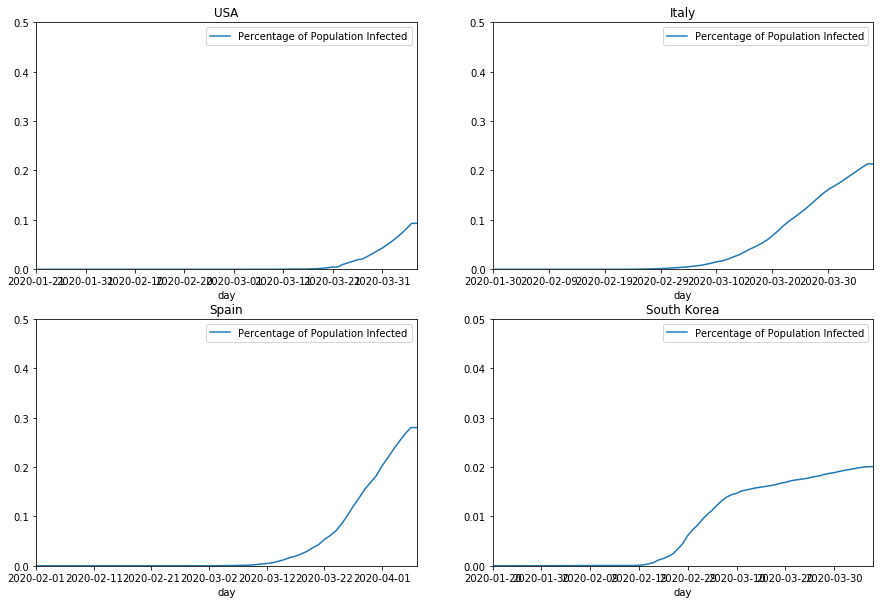

In [7]:
pop_USA = 330565790.
pop_Italy = 60481665.
pop_Spain = 46750728.
pop_SouthKorea = 51259312.
pop_Germany = 83723833.

total_USA.cumulativeconfirmed = total_USA.cumulativeconfirmed/pop_USA*100.

total_Italy.cumulativeconfirmed = total_Italy.cumulativeconfirmed/pop_Italy*100.

total_Spain.cumulativeconfirmed = total_Spain.cumulativeconfirmed/pop_Spain*100.

total_SouthKorea.cumulativeconfirmed = total_SouthKorea.cumulativeconfirmed/pop_SouthKorea*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_USA.cumulativeconfirmed.plot(ax=plt.gca(), title='USA')
plt.legend(['Percentage of Population Infected'])
plt.ylim(0, 0.5)


plt.subplot(2, 2, 2)
total_Italy.cumulativeconfirmed.plot(ax=plt.gca(), title='Italy')
plt.legend(['Percentage of Population Infected'])
plt.ylim(0, 0.5)

plt.subplot(2, 2, 3)
total_Spain.cumulativeconfirmed.plot(ax=plt.gca(), title='Spain')
plt.legend(['Percentage of Population Infected'])
plt.ylim(0, 0.5)

plt.subplot(2, 2, 4)
total_SouthKorea.cumulativeconfirmed.plot(ax=plt.gca(), title='South Korea')
plt.legend(['Percentage of Population Infected'])
plt.ylim(0, 0.05)

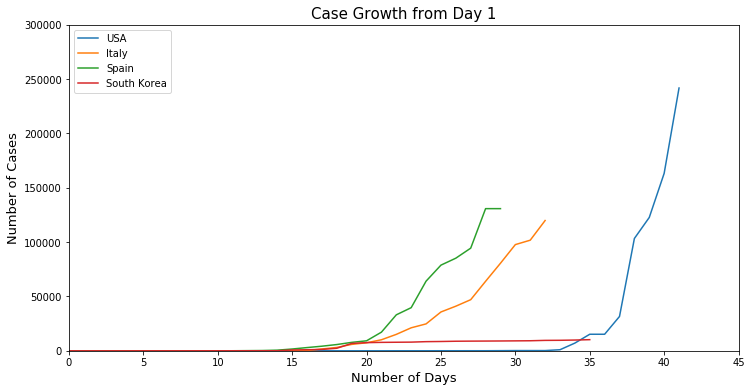

In [8]:
confirmed_USA = train[(train['countryname']=='United States of America') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_USA = train[(train['countryname']=='United States of America') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_USA = confirmed_USA.join(deaths_USA)

confirmed_Italy = train[(train['countryname']=='Italy') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_Italy = train[(train['countryname']=='Italy') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_Italy = confirmed_Italy.join(deaths_Italy)

confirmed_Spain = train[(train['countryname']=='Spain') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_Spain = train[(train['countryname']=='Spain') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_Spain = confirmed_Spain.join(deaths_Spain)

confirmed_SouthKorea= train[(train['countryname']== 'Republic of Korea') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativeconfirmed':['sum']})
deaths_SouthKorea = train[(train['countryname']=='Republic of Korea') & train['cumulativeconfirmed']!=0].groupby(['day']).agg({'cumulativedeaths':['sum']})
total_SouthKorea = confirmed_SouthKorea.join(deaths_SouthKorea)

USA = [i for i in total_USA.cumulativeconfirmed['sum'].values]
USA1 = USA[0:50] 
Italy = [i for i in total_Italy.cumulativeconfirmed['sum'].values]
Italy1 = Italy[0:50] 
Spain = [i for i in total_Spain.cumulativeconfirmed['sum'].values]
Spain1 = Spain[0:50] 
SouthKorea = [i for i in total_SouthKorea.cumulativeconfirmed['sum'].values]
SouthKorea1 = SouthKorea[0:50] 

# Plots
plt.figure(figsize=(12,6))
plt.plot(USA1)
plt.plot(Italy1)
plt.plot(Spain1)
plt.plot(SouthKorea1)
plt.legend(["USA", "Italy", "Spain", "South Korea"], loc='upper left')
plt.title("Case Growth from Day 1", size=15)
plt.xlabel("Number of Days", size=13)
plt.ylabel("Number of Cases", size=13)
plt.ylim(0, 300000)
plt.xlim(0, 45)
plt.show()

In [9]:
newtrain = pd.read_csv("countries2.csv")

newtrain.loc[newtrain['countryname']=='United States of America', 'countryname'] = 'US'

#dates_overlap = ['2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07']
#newtrain = train2.loc[~train2['day'].isin(dates_overlap)]
newdata = pd.concat([newtrain, test], axis = 0, sort=False)

newdata.loc[newdata['day'] >= '2020-04-08', 'cumulativeconfirmed'] = 0
newdata.loc[newdata['day'] >= '2020-04-08', 'cumulativedeaths'] = 0
newdata['day'] = pd.to_datetime(newdata['day'])

# encode date columns to a number
le = preprocessing.LabelEncoder()
newdata['Day_num'] = le.fit_transform(newdata.day)
newdata['Day2'] = newdata['day'].dt.day
newdata['Month'] = newdata['day'].dt.month
newdata['Year'] = newdata['day'].dt.year

# Fill null values given that we merged train-test datasets
newdata['countryname'].fillna("None", inplace=True)
newdata['cumulativeconfirmed'].fillna(0, inplace=True)
newdata['cumulativedeaths'].fillna(0, inplace=True)
newdata['id'].fillna(-1, inplace=True)
newdata['forecastid'].fillna(-1, inplace=True)

display(newdata)
display(newdata.loc[newdata['day'] == '2020-04-08'])

,id,day,countryname,deaths,cumulativedeaths,confirmed,cumulativeconfirmed,forecastid,Day_num,Day2,Month,Year
0,1.0,2020-02-25,Afghanistan,0.0,0.0,1.0,1.0,-1.0,47,25,2,2020
1,2.0,2020-02-26,Afghanistan,0.0,0.0,0.0,1.0,-1.0,48,26,2,2020
2,3.0,2020-02-27,Afghanistan,0.0,0.0,0.0,1.0,-1.0,49,27,2,2020
3,4.0,2020-02-28,Afghanistan,0.0,0.0,0.0,1.0,-1.0,50,28,2,2020
4,5.0,2020-02-29,Afghanistan,0.0,0.0,0.0,1.0,-1.0,51,29,2,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
11576,-1.0,2020-05-10,Zimbabwe,NaN,0.0,NaN,0.0,11577.0,122,10,5,2020
11577,-1.0,2020-05-11,Zimbabwe,NaN,0.0,NaN,0.0,11578.0,123,11,5,2020
11578,-1.0,2020-05-12,Zimbabwe,NaN,0.0,NaN,0.0,11579.0,124,12,5,2020
11579,-1.0,2020-05-13,Zimbabwe,NaN,0.0,NaN,0.0,11580.0,125,13,5,2020


,id,day,countryname,deaths,cumulativedeaths,confirmed,cumulativeconfirmed,forecastid,Day_num,Day2,Month,Year
0,-1.0,2020-04-08,Afghanistan,NaN,0.0,NaN,0.0,1.0,90,8,4,2020
37,-1.0,2020-04-08,Albania,NaN,0.0,NaN,0.0,38.0,90,8,4,2020
74,-1.0,2020-04-08,Algeria,NaN,0.0,NaN,0.0,75.0,90,8,4,2020
111,-1.0,2020-04-08,Andorra,NaN,0.0,NaN,0.0,112.0,90,8,4,2020
148,-1.0,2020-04-08,Angola,NaN,0.0,NaN,0.0,149.0,90,8,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
11396,-1.0,2020-04-08,Vietnam,NaN,0.0,NaN,0.0,11397.0,90,8,4,2020
11433,-1.0,2020-04-08,West Bank and Gaza,NaN,0.0,NaN,0.0,11434.0,90,8,4,2020
11470,-1.0,2020-04-08,Western Sahara,NaN,0.0,NaN,0.0,11471.0,90,8,4,2020
11507,-1.0,2020-04-08,Zambia,NaN,0.0,NaN,0.0,11508.0,90,8,4,2020


In [10]:
missings_count = {col:newdata[col].isnull().sum() for col in newdata.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                         0
deaths               11581
confirmed            11581
id                       0
day                      0
countryname              0
cumulativedeaths         0
cumulativeconfirmed      0
forecastid               0
Day_num                  0
Day2                     0
Month                    0
Year                     0


In [11]:
print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
newdata['countryname'] = le.fit_transform(newdata['countryname'])
number_c = newdata['countryname']
countries = le.inverse_transform(newdata['countryname'])
country_dict = dict(zip(countries, number_c))
display(newdata)

Encoded dataset


,id,day,countryname,deaths,cumulativedeaths,confirmed,cumulativeconfirmed,forecastid,Day_num,Day2,Month,Year
0,1.0,2020-02-25,0,0.0,0.0,1.0,1.0,-1.0,47,25,2,2020
1,2.0,2020-02-26,0,0.0,0.0,0.0,1.0,-1.0,48,26,2,2020
2,3.0,2020-02-27,0,0.0,0.0,0.0,1.0,-1.0,49,27,2,2020
3,4.0,2020-02-28,0,0.0,0.0,0.0,1.0,-1.0,50,28,2,2020
4,5.0,2020-02-29,0,0.0,0.0,0.0,1.0,-1.0,51,29,2,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
11576,-1.0,2020-05-10,229,NaN,0.0,NaN,0.0,11577.0,122,10,5,2020
11577,-1.0,2020-05-11,229,NaN,0.0,NaN,0.0,11578.0,123,11,5,2020
11578,-1.0,2020-05-12,229,NaN,0.0,NaN,0.0,11579.0,124,12,5,2020
11579,-1.0,2020-05-13,229,NaN,0.0,NaN,0.0,11580.0,125,13,5,2020


In [12]:
# X = coral[["year"]]
# y = coral["total"].values.reshape(-1, 1)
# print(X.shape, y.shape)


# plt.scatter(X, y)

# ax = numpy.array(X)
# ay = numpy.array(y)

# ax = numpy.array(X, dtype=numpy.float128)
# ax.shape

# ay = numpy.array(y, dtype=numpy.float128)
# ay.shape

# ax = numpy.array(ax[0:144, 0])
# ax

# ay = numpy.array(ay[0:144, 0])
# ay

# from sklearn.model_selection import train_test_split
# ### BEGIN SOLUTION
# X_train, X_test, y_train, y_test = train_test_split(ax, ay, random_state=42)
# ### END SOLUTION
# X_train, X_test, y_train, y_test

In [13]:
# plt.scatter(newdata.day,newdata.cumulativeconfirmed)

In [14]:
# from sklearn.model_selection import train_test_split
# ### BEGIN SOLUTION
# X_train, X_test, y_train, y_test = train_test_split(ax, ay, random_state=42)
# ### END SOLUTION
# X_train, X_test, y_train, y_test

In [15]:
data = newdata.copy() 
features = ['id', 'forecastid', 'countryname', 'cumulativeconfirmed', 'cumulativedeaths', 'Day_num']
data = data[features]

# Apply log transformation to confirmed cases and deaths

data[['cumulativeconfirmed', 'cumulativedeaths']] = data[['cumulativeconfirmed', 'cumulativeconfirmed']].astype('float64')
data[['cumulativeconfirmed', 'cumulativeconfirmed']] = data[['cumulativeconfirmed', 'cumulativeconfirmed']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


## Split data into train/test
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'forecastid'] = -1
    df = df[df['Day_num']<=test_lim]
    
   # Train set
    x_train = df[df.forecastid == -1].drop(['cumulativeconfirmed', 'cumulativedeaths'], axis=1)
    y_train_1 = df[df.forecastid == -1]['cumulativeconfirmed']
    y_train_2 = df[df.forecastid == -1]['cumulativedeaths']

    # Test set
    x_test = df[df.forecastid != -1].drop(['cumulativeconfirmed', 'cumulativedeaths'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('id', inplace=True, errors='ignore', axis=1)
    x_train.drop('forecastid', inplace=True, errors='ignore', axis=1)
    x_test.drop('id', inplace=True, errors='ignore', axis=1)
    x_test.drop('forecastid', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# # Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

   # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# # Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

   # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    final = pd.DataFrame({
        "forecastid": df['forecastid'].astype('int32'), 
        "cumulativeconfirmed": prediction_1, 
        "cumulativedeaths": prediction_2
    })
#     final.to_csv('final.csv', index=False)

In [16]:
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', 
                 '2020-04-06', '2020-04-07']

In [25]:
newdata.loc[newdata['countryname']==country_dict['Republic of Korea']][10:100]

,id,day,countryname,deaths,cumulativedeaths,confirmed,cumulativeconfirmed,forecastid,Day_num,Day2,Month,Year
5085,5086.0,2020-01-30,169,0.0,0.0,0.0,4.0,-1.0,21,30,1,2020
5086,5087.0,2020-01-31,169,0.0,0.0,2.0,6.0,-1.0,22,31,1,2020
5087,5088.0,2020-02-01,169,0.0,0.0,5.0,11.0,-1.0,23,1,2,2020
5088,5089.0,2020-02-02,169,0.0,0.0,4.0,15.0,-1.0,24,2,2,2020
5089,5090.0,2020-02-03,169,0.0,0.0,0.0,15.0,-1.0,25,3,2,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
5149,5150.0,2020-04-03,169,5.0,174.0,86.0,10062.0,-1.0,85,3,4,2020
5150,5151.0,2020-04-04,169,3.0,177.0,94.0,10156.0,-1.0,86,4,4,2020
5151,5152.0,2020-04-05,169,6.0,183.0,81.0,10237.0,-1.0,87,5,4,2020
5152,5153.0,2020-04-06,169,3.0,186.0,47.0,10284.0,-1.0,88,6,4,2020


In [19]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift, train_lim, test_lim):
    
    data_country = data[data['countryname']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, train_lim, test_lim)
    model, pred = lin_reg(X_train, Y_train_1, X_test)

    # Create a df with both real cases and predictions (predictions starting on March 12th)
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    X_test_check = X_test.copy()
    X_test_check['Target'] = pred

    X_final_check = pd.concat([X_train_check, X_test_check])

    # Select predictions from March 1st to March 25th
    predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = newtrain.loc[(newtrain['countryname']==country_name) & (newtrain['day'].isin(dates_list))]['cumulativeconfirmed']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (from March " + str(1+shift) + " to March 25th)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(30-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (from March " + str(1+shift) + " to March 30th)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))

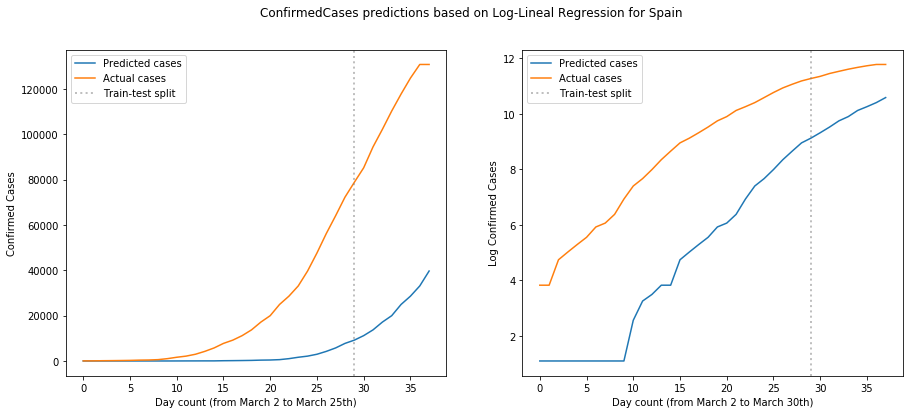

In [20]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day=1
day_start=38+ march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 63, 92
plot_linreg_basic_country(data, country_name, dates_list, day_start, march_day, train_lim, test_lim)

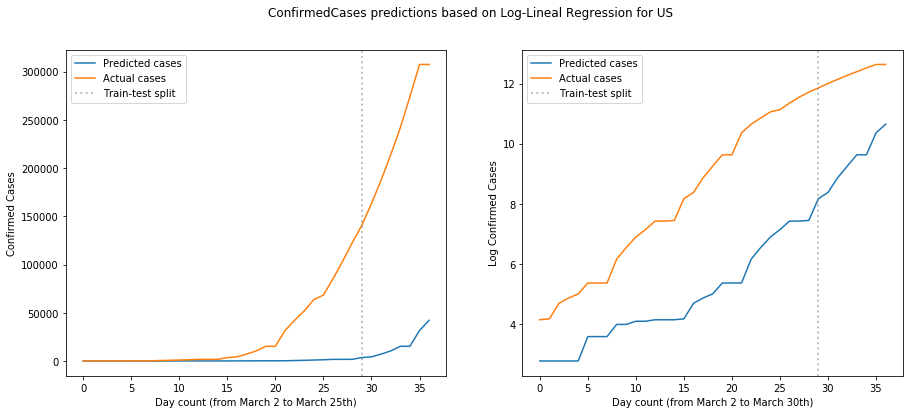

In [21]:
# Filter Spain, run the Linear Regression workflow
country_name = "US"
march_day = 1
day_start = 38+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 63, 112
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

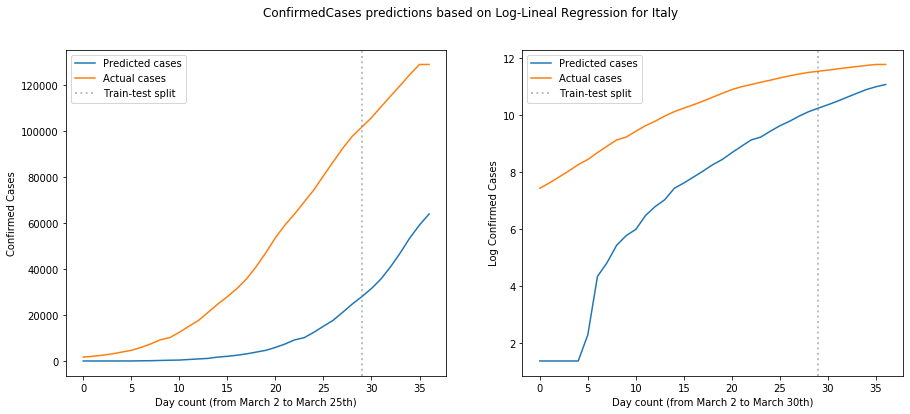

In [22]:
# Filter Spain, run the Linear Regression workflow
country_name = "Italy"
march_day = 1
day_start = 38+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 63, 92
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

In [26]:
# Filter Spain, run the Linear Regression workflow
country_name = "Republic of Korea"
march_day = 1
day_start = 38+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 21, 92
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.